# 9 Features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('husl')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# color hex code
Blue = '#4285FA'
Red = '#EA4335'
Yellow = '#FBBC05'
Green = '#34A853'

In [3]:
loan = pd.read_csv('loan_df.csv')
pd.set_option('display.max_columns', None)

In [4]:
from sklearn.model_selection import train_test_split

X = loan[['int_rate', 'dti', 'revol_util', 'total_acc', 'installment','emp_length',
          'purpose_encoder', 'annual_inc', 'home_ownership_encoder']]
y = loan['is_default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

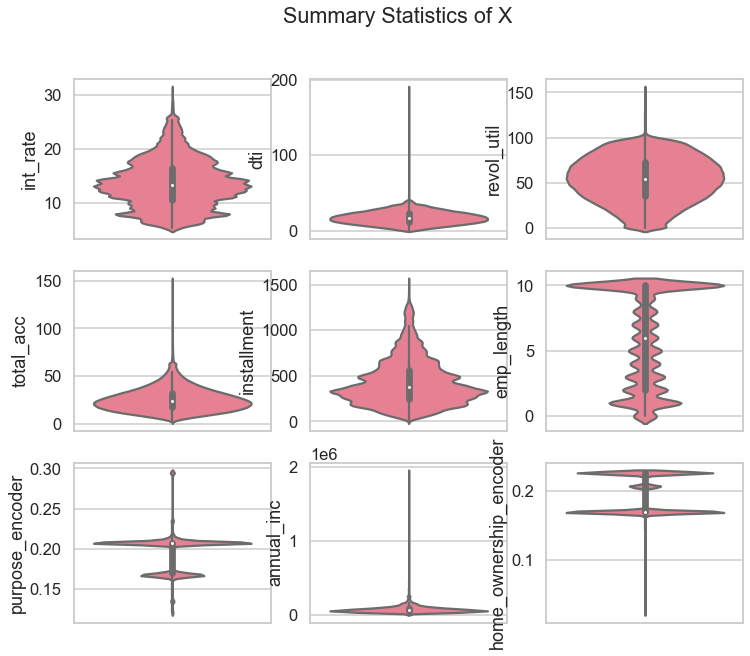

In [5]:
plt.figure(figsize=(12,10))
for i, c in enumerate(X):
    plt.subplot(3,3, i+1)
    sns.violinplot(y=c, data=X)

plt.suptitle('Summary Statistics of X')    
plt.show()

In [6]:
numeric = X_train.columns.difference(['emp_length', 'purpose_encoder', 'home_ownership_encoder'])
category = X_train.columns.difference(numeric)

In [7]:
from sklearn.preprocessing import StandardScaler, RobustScaler
# Fit on Train , transform on Train & Test
scaler = RobustScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

#Scaled Train
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
#Scaled Test
X_test_scaled = scaler.transform(X_test_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

In [8]:
#Sampler Class
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, RandomOverSampler

class Sampler(object):
    sampler = {'SMOTE': SMOTE(random_state=42),
               'SMOTENC': SMOTENC(random_state=42, 
                                  categorical_features=[X_train.columns.get_loc(c) for c in category]), 
               'ADASYN': ADASYN(random_state=42), 
               'RandomOverSampler': RandomOverSampler(random_state=42)}
    def __init__(self, name):
        self.sm = self.sampler[name]
    
    def sampling(self, X_train, y_train):
        X_sampled, y_sampled = self.sm.fit_resample(X_train, y_train)        
        return X_sampled, y_sampled

In [9]:
sampler = Sampler('SMOTENC')
X_train_SMOTENC, y_train_SMOTENC = sampler.sampling(X_train, y_train)
X_train_SMOTENC_scaled, y_train_SMOTENC_scaled = sampler.sampling(X_train_scaled, y_train)

In [10]:
sampler = Sampler('ADASYN')
X_train_ADASYN, y_train_ADASYN = sampler.sampling(X_train, y_train)
X_train_ADASYN_scaled, y_train_ADASYN_scaled = sampler.sampling(X_train_scaled, y_train)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier


class Classifier(object):
    
    classifier = {'LogisticRegression': LogisticRegression(),
                  'AdaBoost': AdaBoostClassifier(),
                  'RandomForest': RandomForestClassifier(),
                  'Neural': MLPClassifier(),
                  'XGBoost': XGBClassifier()}
    
    clf_init_param = {'LogisticRegression': {'random_state':42},
                      
                      'AdaBoost': {'random_state':42}, 
                      
                      'RandomForest': {'random_state':42}, 
                      
                      'Neural': {'random_state':42}, 
                      
                      'XGBoost': {'objective': 'binary:logistic',
                                  'max_delta_step':1,
                                  'min_child_weight':1,
                                  'random_state':42}
                     }
    def __init__(self, name):
        self.name = name
        self.model = self.classifier[name].set_params(**self.clf_init_param[name])

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

class Plot:
    
    def __init__(self):
        pass
    
    def confusion_matrix(y_test, y_pred):
                        
        print(f'Classification Report: \n {classification_report(y_test, y_pred, target_names=["Paid", "Default"])}')
        print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
        
        cm = confusion_matrix(y_test, y_pred)        
        print(f'\nConfusion matrix:\n{cm}')

        
        
        labels = ['Not Default', 'Default']
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, cmap=plt.cm.Blues)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.xlabel('Predicted')
        plt.ylabel('Expected')
        plt.show()
        
    def plot_auc(y_test, y_pred_prob):
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        plt.plot([0,1], [0,1], linestyle='--', color='navy')
        auc_area = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, color='orange', label='Ada (area=%.2f)'%auc_area)
        plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate')
        plt.suptitle('Receiver Operating Characteristic')
        plt.legend()
        plt.show()

In [13]:
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

class Model(object):
    
    def __init__(self):
        pass
    
    def start(name, X_train, y_train, X_test):
        clf = Classifier(name)
        pipe = Pipeline([('clfr', clf.model)])
        pipe.fit(X_train, y_train)
        pipe_preds = pipe.predict(X_test)
        return pipe_preds 

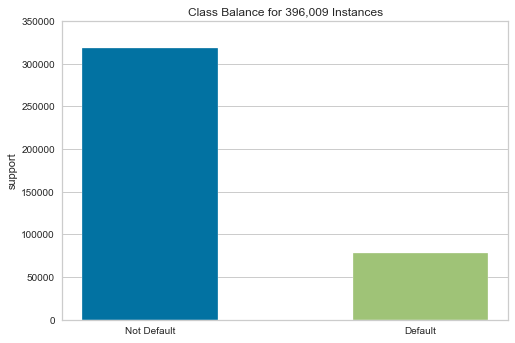

In [14]:
from yellowbrick.target import ClassBalance

def classbalance(y):
    alass = ClassBalance(labels=['Not Default', 'Default'])
    alass.fit(y)
    alass.show()

classbalance(y)

# MODEL 1: Logistic + SMOTENC

Classification Report: 
               precision    recall  f1-score   support

        Paid       0.87      0.44      0.58     63716
     Default       0.24      0.73      0.36     15486

    accuracy                           0.49     79202
   macro avg       0.55      0.58      0.47     79202
weighted avg       0.74      0.49      0.54     79202

Accuracy: 0.49

Confusion matrix:
[[27866 35850]
 [ 4255 11231]]


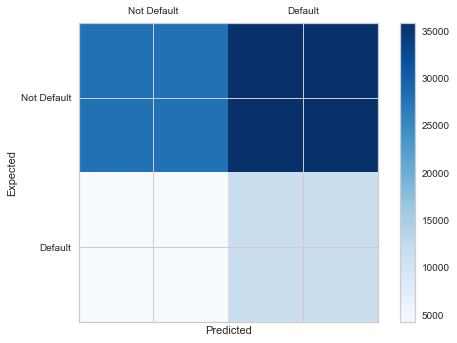

In [15]:
name = 'LogisticRegression'
preds = Model.start(name, X_train_SMOTENC, y_train_SMOTENC, X_test)
Plot.confusion_matrix(y_test, preds)

# Model 2: Ada + SMOTENC + Scaled

Classification Report: 
               precision    recall  f1-score   support

        Paid       0.88      0.63      0.73     63716
     Default       0.30      0.64      0.41     15486

    accuracy                           0.63     79202
   macro avg       0.59      0.64      0.57     79202
weighted avg       0.76      0.63      0.67     79202

Accuracy: 0.63

Confusion matrix:
[[39963 23753]
 [ 5516  9970]]


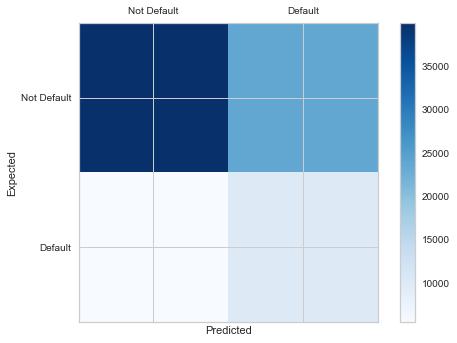

In [16]:
name = 'AdaBoost'
preds = Model.start(name, X_train_SMOTENC_scaled, y_train_SMOTENC_scaled, X_test_scaled)
Plot.confusion_matrix(y_test, preds)

# Model 3: RandomForest + SMOTENC

Classification Report: 
               precision    recall  f1-score   support

        Paid       0.84      0.81      0.82     63716
     Default       0.32      0.37      0.34     15486

    accuracy                           0.72     79202
   macro avg       0.58      0.59      0.58     79202
weighted avg       0.74      0.72      0.73     79202

Accuracy: 0.72

Confusion matrix:
[[51322 12394]
 [ 9702  5784]]


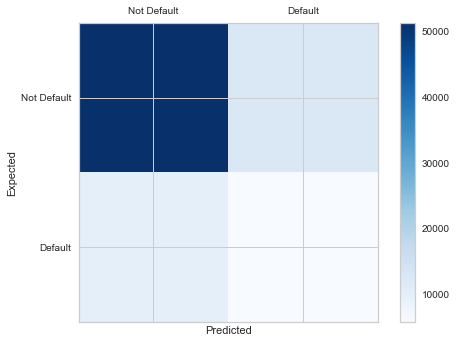

In [17]:
name = 'RandomForest'
preds = Model.start(name, X_train_SMOTENC, y_train_SMOTENC, X_test)
Plot.confusion_matrix(y_test, preds)

# Model 4: Neural + SMOTENC + Scaled

Classification Report: 
               precision    recall  f1-score   support

        Paid       0.88      0.62      0.73     63716
     Default       0.29      0.65      0.40     15486

    accuracy                           0.63     79202
   macro avg       0.59      0.63      0.57     79202
weighted avg       0.76      0.63      0.66     79202

Accuracy: 0.63

Confusion matrix:
[[39618 24098]
 [ 5474 10012]]


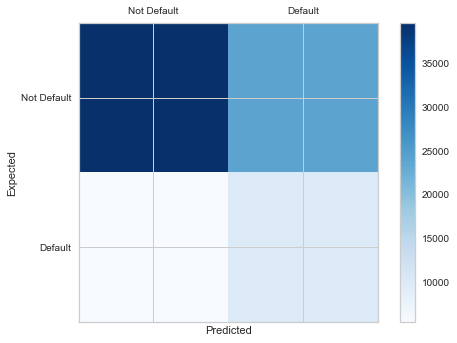

In [18]:
name = 'Neural'
preds = Model.start(name, X_train_SMOTENC_scaled, y_train_SMOTENC_scaled, X_test_scaled)
Plot.confusion_matrix(y_test, preds)

# Model 5: XGBoost + SMOTENC + Scaled

Classification Report: 
               precision    recall  f1-score   support

        Paid       0.83      0.93      0.88     63716
     Default       0.40      0.19      0.26     15486

    accuracy                           0.79     79202
   macro avg       0.61      0.56      0.57     79202
weighted avg       0.74      0.79      0.75     79202

Accuracy: 0.79

Confusion matrix:
[[59380  4336]
 [12553  2933]]


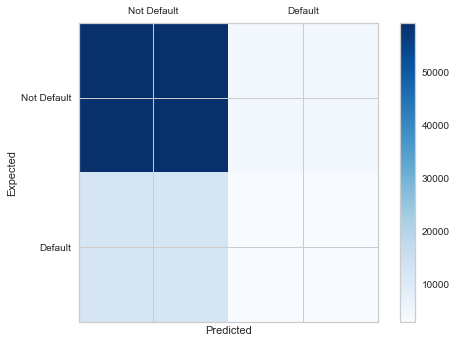

In [19]:
name = 'XGBoost'
preds = Model.start(name, X_train_SMOTENC_scaled, y_train_SMOTENC_scaled, X_test_scaled)
Plot.confusion_matrix(y_test, preds)

# Model 6: Logistic + ADASYN + Scaled

Classification Report: 
               precision    recall  f1-score   support

        Paid       0.88      0.63      0.74     63716
     Default       0.30      0.66      0.41     15486

    accuracy                           0.64     79202
   macro avg       0.59      0.64      0.58     79202
weighted avg       0.77      0.64      0.68     79202

Accuracy: 0.64

Confusion matrix:
[[40403 23313]
 [ 5329 10157]]


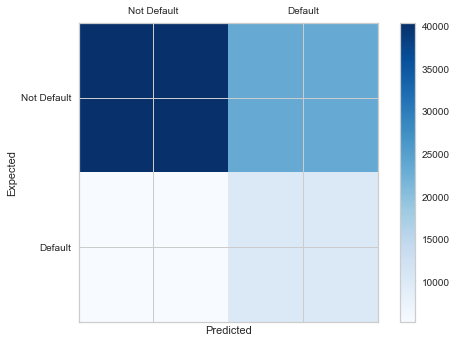

In [20]:
name = 'LogisticRegression'
preds = Model.start(name, X_train_ADASYN_scaled, y_train_ADASYN_scaled, X_test_scaled)
Plot.confusion_matrix(y_test, preds)

# Model 7: XGBoost + Undersampling

In [21]:
from sklearn.utils import resample

# Undersampling
def undersampling(X_train, y_train):
    
    X_full = X_train.copy()
    X_full['target'] = y_train
    X_maj = X_full[X_full.target==0]
    X_min = X_full[X_full.target==1]
    X_maj_rus = resample(X_maj, replace=False, n_samples=len(X_min), random_state=42)
    X_rus = pd.concat([X_maj_rus, X_min])
    X_train_rus = X_rus.drop('target', axis=1)
    y_train_rus = X_rus['target']
    return X_train_rus, y_train_rus

X_train_rus, y_train_rus = undersampling(X_train, y_train)

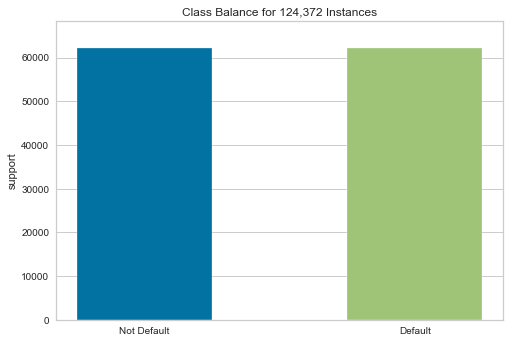

In [22]:
classbalance(y_train_rus)

Classification Report: 
               precision    recall  f1-score   support

        Paid       0.89      0.63      0.74     63716
     Default       0.31      0.67      0.42     15486

    accuracy                           0.64     79202
   macro avg       0.60      0.65      0.58     79202
weighted avg       0.77      0.64      0.68     79202

Accuracy: 0.64

Confusion matrix:
[[40428 23288]
 [ 5099 10387]]


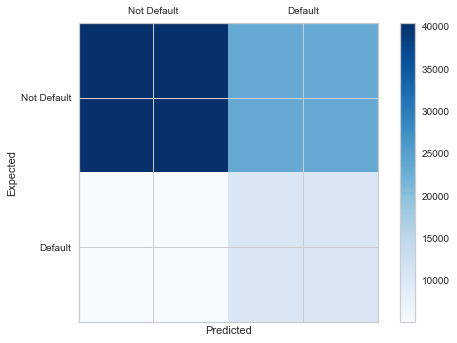

In [23]:
name = 'XGBoost'
preds = Model.start(name, X_train_rus, y_train_rus, X_test)
Plot.confusion_matrix(y_test, preds)

In [24]:
from sklearn.metrics import roc_curve, auc

In [25]:
def proba(model, X_tr, y_tr, X_te, y_te):
    clf = model.fit(X_tr, y_tr)
    prob = clf.predict_proba(X_te)[:,1]
    fpr, tpr, thresholds = roc_curve(y_te, prob)
    prob_auc = auc(fpr, tpr)
    return fpr, tpr, prob_auc

In [26]:
logclf = LogisticRegression()
fpr, tpr, log_auc = proba(logclf, X_train_ADASYN_scaled, y_train_ADASYN_scaled, X_test_scaled, y_test)

In [27]:
adaclf = AdaBoostClassifier()
fpr1, tpr1, ada_auc = proba(adaclf, X_train_SMOTENC_scaled, y_train_SMOTENC_scaled, X_test_scaled, y_test )

In [28]:
rfc = RandomForestClassifier()
fpr2, tpr2, rfc_auc = proba(rfc, X_train_SMOTENC, y_train_SMOTENC, X_test, y_test)

In [29]:
neu = MLPClassifier()
fpr3, tpr3, neu_auc = proba(neu, X_train_SMOTENC_scaled, y_train_SMOTENC_scaled, X_test_scaled, y_test)

In [30]:
xg = XGBClassifier()
fpr4, tpr4, xg_auc = proba(xg, X_train_rus, y_train_rus, X_test, y_test )

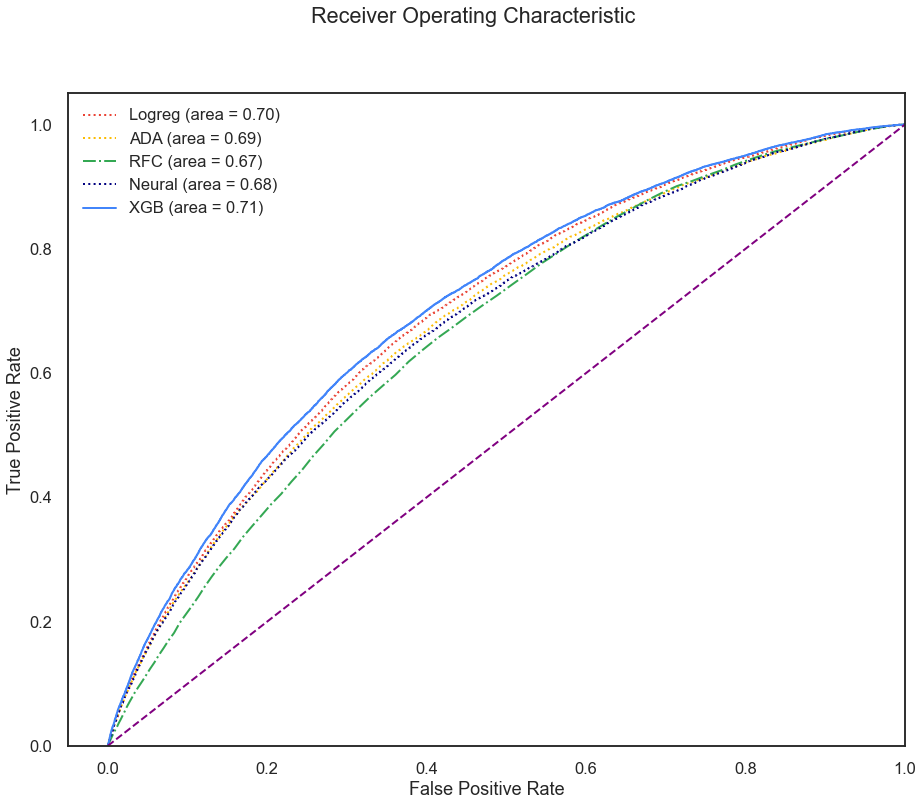

In [31]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(15,12))
plt.plot(fpr, tpr, lw=2, label='Logreg (area = %.2f)' %log_auc, linestyle=':', color=Red)
plt.plot(fpr1, tpr1, lw=2, label='ADA (area = %.2f)' %ada_auc, linestyle=':', color=Yellow)
plt.plot(fpr2, tpr2, lw=2, label='RFC (area = %.2f)' %rfc_auc,linestyle='-.', color=Green)
plt.plot(fpr3, tpr3, lw=2, label='Neural (area = %.2f)' %neu_auc, linestyle=':', color='navy')
plt.plot(fpr4, tpr4, lw=2, label='XGB (area = %.2f)' %xg_auc, color=Blue)         

plt.plot([0,1], [0,1], lw=2, color='purple', linestyle='--')
plt.xlim([-0.05,1]), plt.ylim([0,1.05])
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate')
plt.suptitle('Receiver Operating Characteristic')
plt.legend()
plt.savefig('ROCz')

## Actual vs Prediction

In [32]:
# Using Model with the best Recall 
logreg = LogisticRegression()
logreg.fit(X_train_SMOTENC, y_train_SMOTENC)
log_pred = logreg.predict(X)
pred_df = pd.DataFrame(log_pred, columns=['prediction'])

In [33]:
actual = pd.read_csv('actual.csv', parse_dates=['issue_d'])
actual = pd.concat([actual, pred_df], axis=1)
df = actual[['loan_status', 'prediction', 'issue_d']]
df['loan_status'] = df.loan_status.map({'Fully Paid': 0, 'Charged Off': 1})

In [34]:
df_a = df.resample('M', on='issue_d').agg({'loan_status': 'sum', 'prediction': 'sum'}).reset_index()

In [35]:
mean = df_a.loan_status.mean()

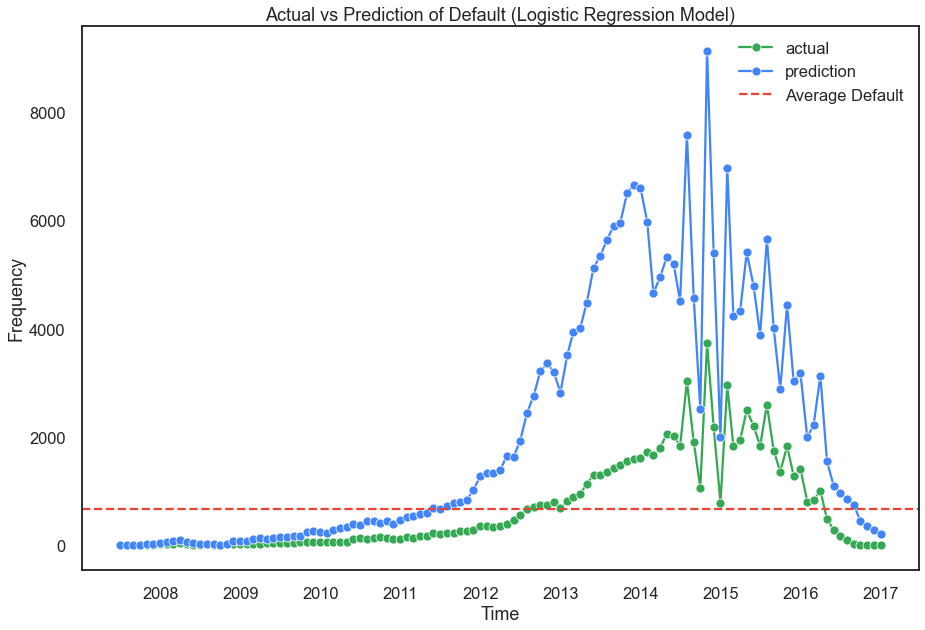

In [36]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(df_a.issue_d, df_a.loan_status, label='actual', marker='o', color=Green)
sns.lineplot(df_a.issue_d, df_a.prediction, label='prediction', marker='o', color=Blue)
ax.set_xlabel('Time'); ax.set_ylabel('Frequency')
ax.set_title("Actual vs Prediction of Default (Logistic Regression Model)")
ax.axhline(mean, ls='--', color=Red, label='Average Default')
plt.legend()